In [2]:
 !mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 586M/586M [00:21<00:00, 30.9MB/s]
100% 586M/586M [00:21<00:00, 29.0MB/s]


In [4]:
import zipfile

extract_dir = 'AnimalExtractedFiles'
zip_data = zipfile.ZipFile('/content/animals10.zip')
zip_data.extractall(extract_dir)
zip_data.close()

In [5]:
import zipfile
import os
from PIL import Image
import numpy as np

# Exploratory Data Analysis

In [6]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Extract Dataset
extract_dir = 'AnimalExtractedFiles'
zip_path = '/content/animals10.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_data:
    zip_data.extractall(extract_dir)

# Correct dataset path
dataset_path = os.path.join(extract_dir, 'raw-img')

# Step 2: Define Image Parameters
image_size = (128, 128)
batch_size = 32  # Adjust based on RAM

if not os.path.exists(dataset_path):
    print(f"Error: Dataset folder '{dataset_path}' not found!")

# Step 3: Define Data Generators (With Train, Val, and Test Splits)
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.3)  # 30% for val+test

# Train (70% of total data)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

# Temp Validation+Test (30% of total data)
temp_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

# Step 4: Manually Split Validation & Test (Half of temp_data each)
val_size = int(0.5 * temp_generator.samples)  # 15% of total data
test_size = temp_generator.samples - val_size  # Remaining 15%

# Manually create validation and test generators
val_generator = tf.keras.preprocessing.image.DirectoryIterator(
    dataset_path,
    temp_generator.image_data_generator,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

test_generator = tf.keras.preprocessing.image.DirectoryIterator(
    dataset_path,
    temp_generator.image_data_generator,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False  # Keep test set fixed
)

# Step 5: Print Summary
print(f"Total training samples: {train_generator.samples}")
print(f"Total validation samples: {val_size}")
print(f"Total test samples: {test_size}")



Found 18331 images belonging to 10 classes.
Found 7848 images belonging to 10 classes.
Found 7848 images belonging to 10 classes.
Found 7848 images belonging to 10 classes.
Total training samples: 18331
Total validation samples: 3924
Total test samples: 3924


In [7]:
import tensorflow as tf
import os

# Step 1: Define Dataset Path
dataset_folder = "AnimalExtractedFiles/raw-img"  # Folder containing images

# Step 2: Define Image Parameters
image_size = (128, 128)
batch_size = 32
seed = 42  # Ensures reproducibility

# Step 3: Create Train, Validation, and Test Datasets
# 70% Train, 15% Validation, 15% Test
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.3,  # 30% goes to val+test
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_folder,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

# Step 4: Further Split Validation & Test from 30%
val_size = int(0.5 * val_test_ds.cardinality().numpy())  # 15% for validation
test_size = val_test_ds.cardinality().numpy() - val_size  # Remaining 15% for test

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# Step 5: Display Dataset Information
print(f"Class names: {train_ds.class_names}")
print(f"Train batches: {train_ds.cardinality().numpy()}")
print(f"Validation batches: {val_ds.cardinality().numpy()}")
print(f"Test batches: {test_ds.cardinality().numpy()}")

# Step 6: Verify Dataset Structure
for images, labels in train_ds.take(1):
    print(f"Train batch image shape: {images.shape}")

for images, labels in val_ds.take(1):
    print(f"Validation batch image shape: {images.shape}")

for images, labels in test_ds.take(1):
    print(f"Test batch image shape: {images.shape}")


Found 26179 files belonging to 10 classes.
Using 18326 files for training.
Found 26179 files belonging to 10 classes.
Using 7853 files for validation.
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Train batches: 573
Validation batches: 123
Test batches: 123
Train batch image shape: (32, 128, 128, 3)
Validation batch image shape: (32, 128, 128, 3)
Test batch image shape: (32, 128, 128, 3)


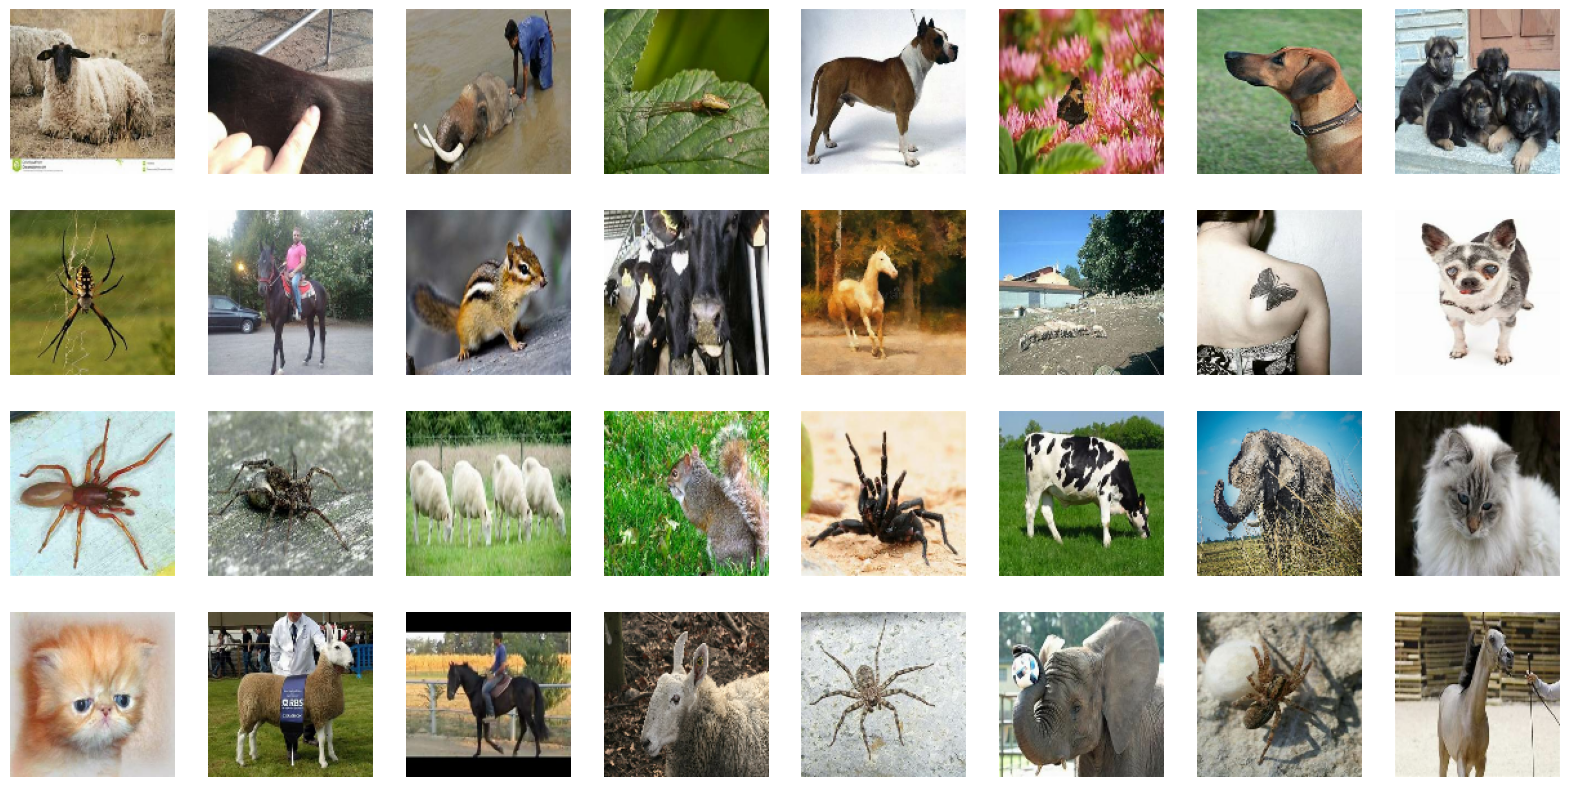

In [8]:
import matplotlib.pyplot as plt

# Display resized images from training dataset
for images, labels in train_ds.take(1):  # Take one batch from the dataset
    plt.figure(figsize=(20, 10))  # Adjust figure size

    num_images = min(32, images.shape[0])  # Limit to batch size (32)

    for i in range(num_images):
        plt.subplot(4, 8, i + 1)  # Arrange in a 4x8 grid
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

    plt.show()


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling

# Define dataset path
dataset_path = "AnimalExtractedFiles/raw-img"

# Load dataset with train-test split
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(128, 128),
    batch_size=32,
    shuffle=True  # Shuffle to prevent ordering bias
)

# Normalize dataset using Rescaling layer
normalization_layer = Rescaling(1./255)  # Converts range [0,255] → [0,1]
normalized_dataset = dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Verify normalization
for images, labels in normalized_dataset.take(1):
    print(f"Image pixel range: {tf.reduce_min(images).numpy()} to {tf.reduce_max(images).numpy()}")


Found 26179 files belonging to 10 classes.
Image pixel range: 0.0 to 1.0


In [10]:
def handle_color_channels(image, label):
    # Extract individual color channels
    red_channel = image[:, :, :, 0]  # Red channel
    green_channel = image[:, :, :, 1]  # Green channel
    blue_channel = image[:, :, :, 2]  # Blue channel

    # Set the Red channel to zero
    red_channel = tf.zeros_like(red_channel)

    # Stack the modified channels back together (keeping batch shape intact)
    image = tf.concat([
        tf.expand_dims(red_channel, axis=-1),
        tf.expand_dims(green_channel, axis=-1),
        tf.expand_dims(blue_channel, axis=-1)
    ], axis=-1)

    return image, label


In [11]:
# Define dataset path
dataset_path = "AnimalExtractedFiles/raw-img"
image_size = (128, 128)
batch_size = 32

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True  # Ensures randomness
)

# Apply color channel transformation
processed_dataset = dataset.map(handle_color_channels, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize pipeline performance
processed_dataset = (
    processed_dataset
    .cache()  # Optional: Speeds up access
    .shuffle(buffer_size=1000)  # Shuffle dataset
    .batch(batch_size)  # Batch after shuffling
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Optimize loading
)

# Verify dataset processing
for images, labels in processed_dataset.take(1):
    print(f"Processed Image Shape: {images.shape}")
    print(f"Labels: {labels.numpy()}")


Found 26179 files belonging to 10 classes.
Processed Image Shape: (32, 32, 128, 128, 3)
Labels: [[0 0 7 ... 9 6 8]
 [0 0 3 ... 5 2 8]
 [9 8 9 ... 9 7 3]
 ...
 [1 0 0 ... 1 8 6]
 [0 6 3 ... 1 8 5]
 [6 4 9 ... 0 0 0]]


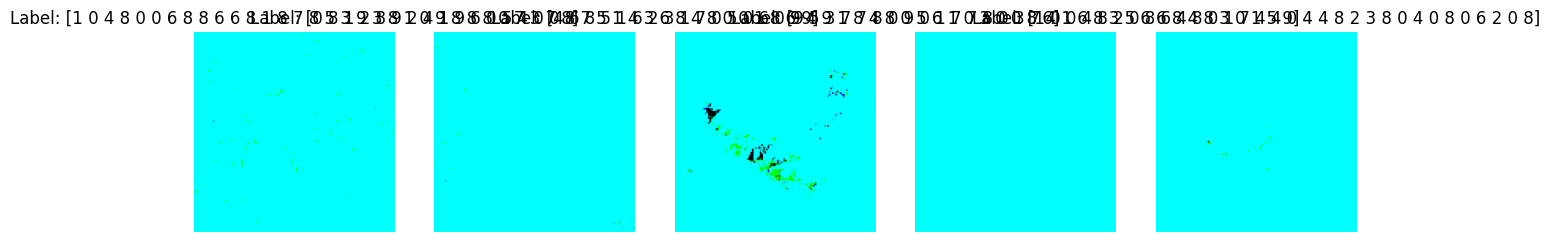

In [12]:
import matplotlib.pyplot as plt

# Take one batch
for batch_images, batch_labels in processed_dataset.take(1):
    plt.figure(figsize=(15, 5))

    for i in range(5):  # Display first 5 images
        plt.subplot(1, 5, i + 1)

        # Extract a single image correctly
        image = batch_images[i]  # Extract single image (no `.numpy()` yet)

        if len(image.shape) == 4:  # If batch dim is still there, remove it
            image = image[0]

        image = image.numpy()  # Convert to NumPy after ensuring correct shape
        label = batch_labels[i].numpy()

        if image.shape[-1] != 3:
            print(f"Warning: Image shape {image.shape} is not (128, 128, 3).")

        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Label: {label}")

    plt.show()


Found 26179 files belonging to 10 classes.


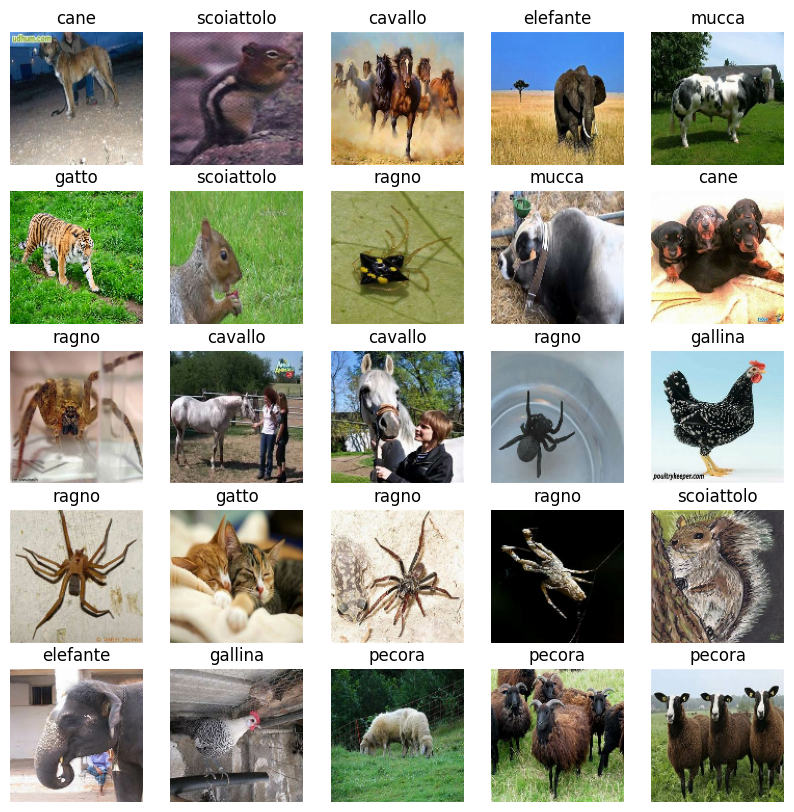

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "AnimalExtractedFiles/raw-img",
    image_size=(128, 128),
    batch_size=32
)

# Get class names
class_names = dataset.class_names

# Display sample images from different classes
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):  # Take a single batch
    for i in range(25):  # Show 25 images
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

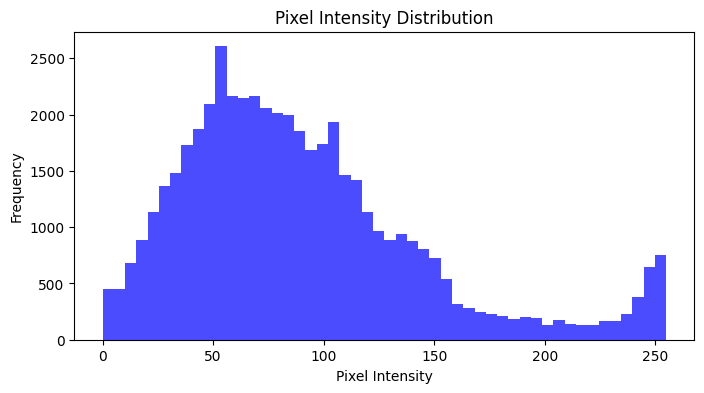

In [16]:
# Get one batch of images
for images, _ in dataset.take(1):
    image_sample = images[0].numpy().astype("uint8")

# Flatten image to 1D for histogram
pixel_values = image_sample.flatten()

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution")
plt.show()

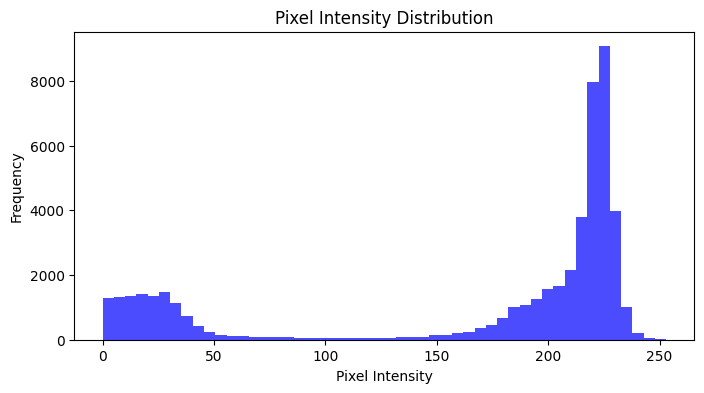

In [17]:
# Get one batch of images
for images, _ in dataset.take(1):
    image_sample = images[0].numpy().astype("uint8")

# Flatten image to 1D for histogram
pixel_values = image_sample.flatten()

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution")
plt.show()

# Model Building (Using Transfer Learning)

## ResNet-50

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications

# Load the ResNet-50 model as a base
base_model = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False  # Freeze the base model

# Define the new model using ResNet-50 as feature extractor
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_ds.class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.6591 - loss: 1.1405 - val_accuracy: 0.8570 - val_loss: 0.4456
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.8116 - loss: 0.5895 - val_accuracy: 0.8714 - val_loss: 0.4063
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.8317 - loss: 0.5033 - val_accuracy: 0.8745 - val_loss: 0.3945
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.8476 - loss: 0.4623 - val_accuracy: 0.8735 - val_loss: 0.4072
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8579 - loss: 0.4284 - val_accuracy: 0.8770 - val_loss: 0.4050
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.8665 - loss: 0.3936 - val_accuracy: 0.8874 - val_loss: 0.3778
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.8786 - loss: 0.3637 - val_accuracy: 0.8753 - val_loss: 0.4157
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8726 - loss: 0.3613 - 

In [20]:
model.save("animal_model_resnet50.h5")

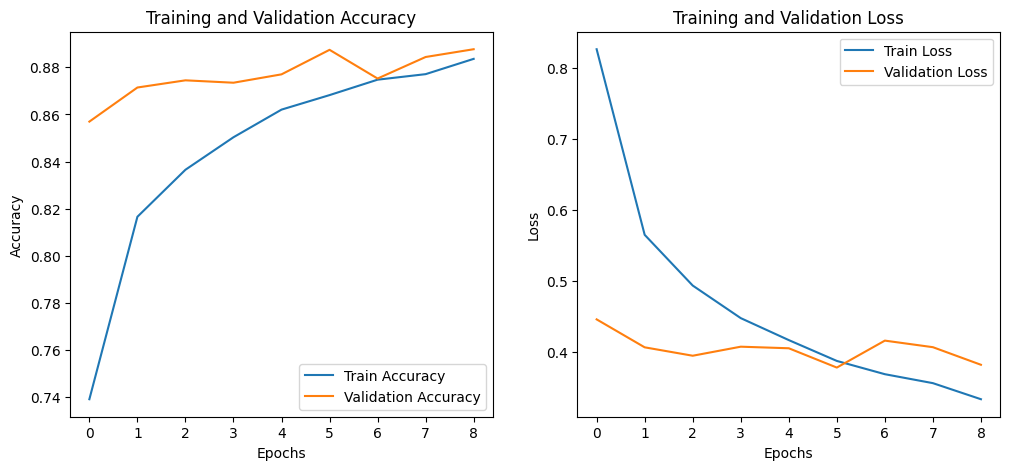

In [21]:
from tensorflow.keras import layers, applications
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

### GRAD-CAM to be done

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the trained model
model = keras.models.load_model("animal_model_resnet50.h5")

# Ensure the model has an input tensor
if model.input is None:
    raise ValueError("The model does not have a defined input. Ensure it was saved correctly.")

# Function to compute Grad-CAM
def compute_gradcam(img_array, model, layer_name):
    layer = model.get_layer(layer_name)
    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions, axis=-1)[0]
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    conv_outputs *= pooled_grads[..., tf.newaxis, tf.newaxis]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

# Function to overlay Grad-CAM heatmap on an image
def overlay_gradcam(image, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlay

# Get last convolutional layer name for ResNet-50
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if hasattr(layer, 'layers'):
            for sub_layer in reversed(layer.layers):
                if isinstance(sub_layer, tf.keras.layers.Conv2D):
                    return sub_layer.name
    raise ValueError("No convolutional layer found in the model.")

gradcam_layer = get_last_conv_layer(model)

# Load a sample image (Modify this to load an actual test image)
image_path = "sample_image.jpg"  # Replace with actual test image path
image = keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
img_array = keras.preprocessing.image.img_to_array(image)
img_array = np.expand_dims(img_array, axis=0)

# Compute Grad-CAM heatmap
heatmap = compute_gradcam(img_array, model, gradcam_layer)
original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (128, 128))
gradcam_img = overlay_gradcam(original_image, heatmap)

# Display Grad-CAM result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(gradcam_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis("off")

plt.show()


AttributeError: The layer sequential has never been called and thus has no defined input.

1/1 ━━━━━━━━━━━━━━━━━━━━ 114s 114s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━

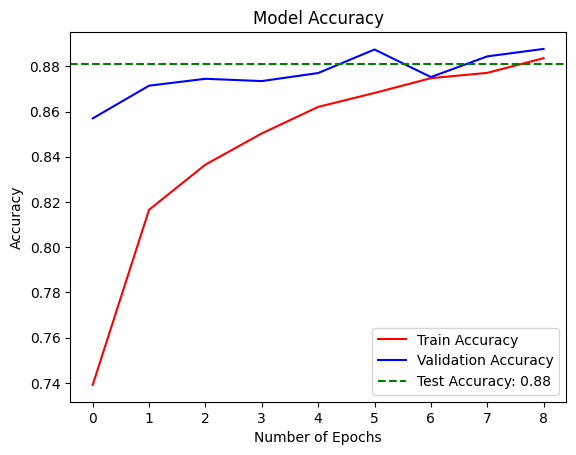

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model("animal_model_resnet50.h5")

# Assuming test_ds is a batched TensorFlow dataset with (batch of images, batch of labels)
y_true = []
y_pred = []

# Iterate through test dataset
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy().astype(int)  # Directly use labels as integers

    y_pred.extend(predicted_classes)
    y_true.extend(true_classes)

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute test accuracy
test_acc = np.mean(y_pred == y_true)
print(f'Test Accuracy: {test_acc:.2f}')

# Plot accuracy curves
plt.plot(history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.axhline(y=test_acc, color='g', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}')
plt.title('Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### GRAD-CAMM to be done

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the trained model
model = keras.models.load_model("animal_model_resnet50.h5")

# Ensure the model has an input tensor
if model.input is None:
    raise ValueError("The model does not have a defined input. Ensure it was saved correctly.")

# Function to compute Grad-CAM
def compute_gradcam(img_array, model, layer_name):
    layer = model.get_layer(layer_name)
    grad_model = tf.keras.models.Model(
        inputs=model.input, outputs=[layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions, axis=-1)[0]
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    conv_outputs *= pooled_grads[..., tf.newaxis, tf.newaxis]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

# Function to overlay Grad-CAM heatmap on an image
def overlay_gradcam(image, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlay

# Get last convolutional layer name for ResNet-50
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if hasattr(layer, 'layers'):
            for sub_layer in reversed(layer.layers):
                if isinstance(sub_layer, tf.keras.layers.Conv2D):
                    return sub_layer.name
    raise ValueError("No convolutional layer found in the model.")

gradcam_layer = get_last_conv_layer(model)

# Load a sample image (Modify this to load an actual test image)
image_path = "sample_image.jpg"  # Replace with actual test image path
image = keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
img_array = keras.preprocessing.image.img_to_array(image)
img_array = np.expand_dims(img_array, axis=0)

# Compute Grad-CAM heatmap
heatmap = compute_gradcam(img_array, model, gradcam_layer)
original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (128, 128))
gradcam_img = overlay_gradcam(original_image, heatmap)

# Display Grad-CAM result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(gradcam_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis("off")

plt.show()


AttributeError: The layer sequential has never been called and thus has no defined input.

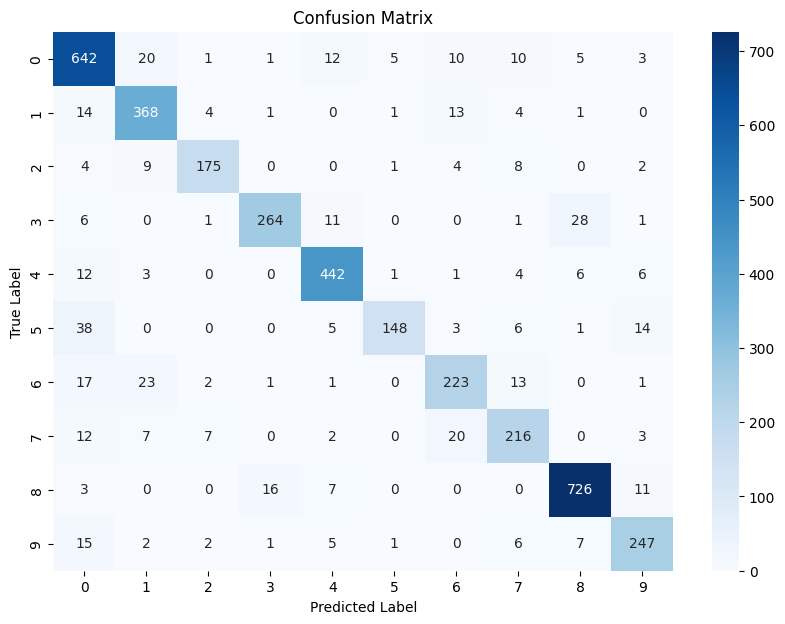

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       709
           1       0.85      0.91      0.88       406
           2       0.91      0.86      0.89       203
           3       0.93      0.85      0.89       312
           4       0.91      0.93      0.92       475
           5       0.94      0.69      0.80       215
           6       0.81      0.79      0.80       281
           7       0.81      0.81      0.81       267
           8       0.94      0.95      0.94       763
           9       0.86      0.86      0.86       286

    accuracy                           0.88      3917
   macro avg       0.88      0.86      0.87      3917
weighted avg       0.88      0.88      0.88      3917



In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

## DenseNet

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications

# Load the DenseNet model as a base
base_model = applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False  # Freeze the base model

# Define the new model using DenseNet as feature extractor
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_ds.class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [30]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 85s 87ms/step - accuracy: 0.2162 - loss: 3.3125 - val_accuracy: 0.3653 - val_loss: 1.8493
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - accuracy: 0.3148 - loss: 1.9496 - val_accuracy: 0.4157 - val_loss: 1.6754
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.3547 - loss: 1.8002 - val_accuracy: 0.4533 - val_loss: 1.5733
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.3763 - loss: 1.7265 - val_accuracy: 0.4868 - val_loss: 1.5236
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.3905 - loss: 1.6967 - val_accuracy: 0.4817 - val_loss: 1.4643
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.4082 - loss: 1.6471 - val_accuracy: 0.5158 - val_loss: 1.4446
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.4131 - loss: 1.6273 - val_accuracy: 0.5196 - val_loss: 1.4172
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.4206 - loss: 1.6113 - 

In [31]:
model.save("animal_model_densenet.h5")

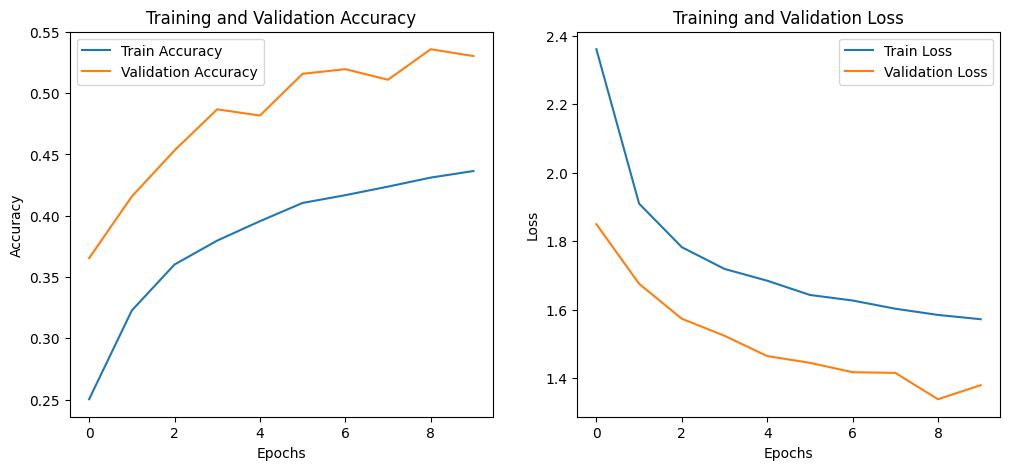

In [32]:
from tensorflow.keras import layers, applications
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

### GRAD-CAMM to be done

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import backend as K

# Load pre-trained DenseNet model
model = DenseNet121(weights='imagenet')
model.trainable = False

# Function to compute saliency map
def compute_saliency_map(model, image):
    image = tf.image.resize(image, (224, 224))  # Ensure correct input size
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = preprocess_input(image)  # Apply preprocessing

    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        top_class = tf.argmax(predictions[0])  # Get the top predicted class
        loss = predictions[:, top_class]  # Use class score as loss

    gradients = tape.gradient(loss, image)  # Compute gradients
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)  # Aggregate over RGB channels
    return saliency[0]  # Remove batch dimension

# Function to display saliency map
def show_saliency_map(image, saliency_map):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title("Saliency Map")
    plt.axis("off")
    plt.show()

# Display saliency maps for 10 training images
for i, (image, label) in enumerate(train_ds.take(10)):  # Take first 10 images
    saliency_map = compute_saliency_map(model, image)
    show_saliency_map(image, saliency_map)


33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


ValueError: Input 0 of layer "densenet121" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 32, 224, 224, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━

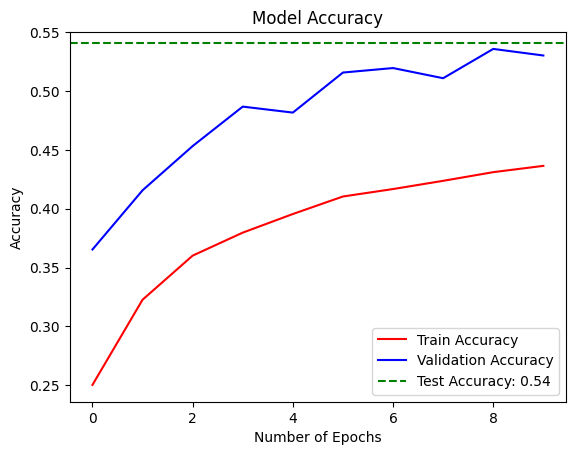

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model("animal_model_densenet.h5")

# Assuming test_ds is a batched TensorFlow dataset with (batch of images, batch of labels)
y_true = []
y_pred = []

# Iterate through test dataset
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy().astype(int)  # Directly use labels as integers

    y_pred.extend(predicted_classes)
    y_true.extend(true_classes)

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute test accuracy
test_acc = np.mean(y_pred == y_true)
print(f'Test Accuracy: {test_acc:.2f}')

# Plot accuracy curves
plt.plot(history.history['accuracy'], color='r', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.axhline(y=test_acc, color='g', linestyle='--', label=f'Test Accuracy: {test_acc:.2f}')
plt.title('Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### GRAD-CAMM to be done

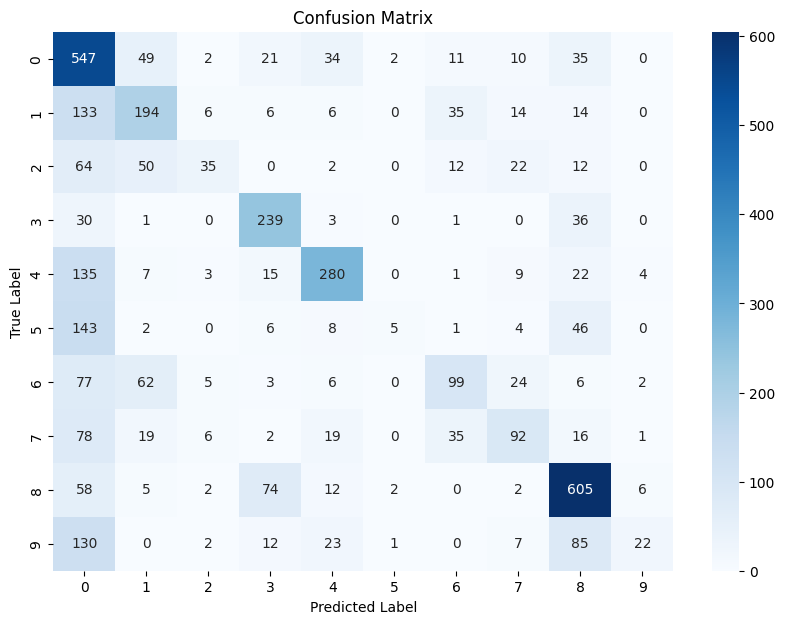

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.77      0.52       711
           1       0.50      0.48      0.49       408
           2       0.57      0.18      0.27       197
           3       0.63      0.77      0.69       310
           4       0.71      0.59      0.64       476
           5       0.50      0.02      0.04       215
           6       0.51      0.35      0.41       284
           7       0.50      0.34      0.41       268
           8       0.69      0.79      0.74       766
           9       0.63      0.08      0.14       282

    accuracy                           0.54      3917
   macro avg       0.56      0.44      0.44      3917
weighted avg       0.57      0.54      0.51      3917



In [34]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

# The ResNet-50 has more accurate performance than DenseNet.